# Machine Learning in Python - Group Project 1

**Due Friday, March 10th by 16.00 pm.**

Benjamin Chooyin, Estelle McCool, Brad Wang, Alyssa Heggison (Group 26) 

## General Setup

In [1]:
# Add any additional libraries or submodules below

#Unhash  the line of code below to install tqdmn if needed
!pip install tqdm

# Data libraries
import numpy as np
import pandas as pd
import string
from tqdm import tqdm

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules that are necessary
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
# Load data
data = pd.read_csv("the_office.csv")
data = pd.DataFrame(data)

# Load additional data from [2]
data_scripts = pd.read_csv('datasets/the_office_lines_scripts.csv')
data_scripts = pd.DataFrame(data_scripts)

## 1. Introduction
In this report we outline the machine learning techinques we used to gain insight into the most important factors for an episode of the office to have a 'good' imdb rating. By 'good' we mean factors that by their inclusion/omission resulted in the greatest possible increases in imdb rating. We focused on factors that were actionable, as if a factor was a good indicator of score but out of the production teams control, there's little insight to be gained from analysing it.

We used a combination of the original database provided and an additonal database of office scripts which allowed us to measure how much each character appeared in a given episode. We fixed any mistakes in the databases and filled gaps where appropriate. 


Then to explore the possible machine learning approaches we first used just linear regression as a baseline to compare to, and then explored 3 possible approaches that could improve upon it. We looked at a ridge rigression, polynomial regression, and a polynomial-ridge regression. We found that the ridge regression was the most effective and we used this to guide our recommendations. We then used our model to examine which factors had the biggest impact on the overall rating of the episode, we found that number of lines and number of directions had a biggest impact which we attribtued to episodes with lots of dialogues and action, and also perhaps to longer episodes. We also could make some recommendations about possible writers and directros and featured characters but we have less evidence to support these recommendations.


## 2. Exploratory Data Analysis and Feature Engineering

Firstly we do exploratory data analysis to get an overview of the data. We plotted a sample of the dataset to get an idea of what the dataset looked like and then obtained a summary information table to review data types and to check for missing values. 

In [3]:
data.sample(5)

,season,episode,episode_name,director,writer,imdb_rating,total_votes,air_date,n_lines,n_directions,n_words,n_speak_char,main_chars
60,4,14,Chair Model,Jeffrey Blitz,B.J. Novak,8.1,2095,2008-04-17,220,61,2680,20,Andy;Angela;Creed;Dwight;Jim;Kevin;Michael;Osc...
131,7,18,Todd Packer,Randall Einhorn,Amelie Gillette,7.5,1581,2011-02-24,313,90,3327,19,Andy;Angela;Dwight;Erin;Jim;Kelly;Kevin;Meredi...
15,2,10,Christmas Party,Charles McDougall,Michael Schur,8.8,2755,2005-12-06,283,42,2788,20,Angela;Creed;Darryl;Dwight;Jim;Kelly;Kevin;Mer...
100,6,11,Shareholder Meeting,Charles McDougall,Justin Spitzer,8.2,1726,2009-11-19,267,46,3064,27,Andy;Creed;Dwight;Erin;Jim;Kevin;Meredith;Mich...
16,2,11,Booze Cruise,Ken Kwapis,Greg Daniels,8.6,2679,2006-01-05,223,11,2534,16,Angela;Darryl;Dwight;Jim;Kelly;Meredith;Michae...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   season        186 non-null    int64  
 1   episode       186 non-null    int64  
 2   episode_name  186 non-null    object 
 3   director      186 non-null    object 
 4   writer        186 non-null    object 
 5   imdb_rating   186 non-null    float64
 6   total_votes   186 non-null    int64  
 7   air_date      186 non-null    object 
 8   n_lines       186 non-null    int64  
 9   n_directions  186 non-null    int64  
 10  n_words       186 non-null    int64  
 11  n_speak_char  186 non-null    int64  
 12  main_chars    186 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 19.0+ KB


A few observations could be made.

1. The data contains numerical values and strings, where the latter needs to be encoded to be utilised by the model.
2. The columns $\texttt{season}$, $\texttt{episode}$ and $\texttt{total\_votes}$ are not controllable in terms of film producing, and so should not be considered as inputs of the final model. However, we could still test their correlations with the rating. 
3. The column $\texttt{air\_date}$ needs to be transformed (e.g. into the number of days from the eariliest airdate) to be used as a numerical variable. 
4. The strings of the columns $\texttt{writers}$ and $\texttt{main\_chars}$ are writer/character names separated by $\textbf{;}$, and we would split them and then encode the apprearance of each individual writer/character. 
5. The name of a episode might have effects on the number of people who decide to watch it, and thereby the number of votes it gets. However, considering we have a relatively small dataset (186 observations), the analysis of the effects of episode names, which would be much likely based on natural language processing and semantic analysis, is not practical here. Thus we won't use this information.
6. There are no missing values in the data.

We further take a look at the scaling and distribution of the features of the data. Then we consider the correlation between features, and between each feature and the response variable IMDB Rating. 

Then we used a summary table to get an idea of the distribution of our numerical data. 

In [5]:
data.describe()

,season,episode,imdb_rating,total_votes,n_lines,n_directions,n_words,n_speak_char
count,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000
mean,5.462366,12.478495,8.250538,2129.543011,296.397849,50.150538,3053.510753,20.693548
std,2.398464,7.233710,0.535168,790.787586,81.998568,23.941797,799.271717,5.092407
min,1.000000,1.000000,6.700000,1393.000000,131.000000,11.000000,1098.000000,12.000000
25%,3.000000,6.000000,7.900000,1628.500000,255.250000,34.000000,2670.250000,17.000000
50%,6.000000,12.000000,8.200000,1954.000000,281.000000,46.000000,2872.500000,20.000000
75%,7.750000,18.000000,8.600000,2385.000000,314.500000,60.000000,3141.000000,23.000000
max,9.000000,28.000000,9.700000,7934.000000,625.000000,166.000000,6076.000000,54.000000


The data contains 186 episodes with a mean amount of votes 2130 per episode and a mean rating of 8.25. Imdb scores ranged from 6.7-9.7.
Many of the possible numerical features are of quite different scales, which implies normalisation might need to be performed.


We also can use a pair plot, in which each pair of variables is plotted against eachother to observe any possible relationships. We used this to look for variables that are highly correlated and so might provide very similar information to the model, and so could be removed. We also considered which variables appear to have some relationship with imdb_rating and hence might be useful as predictors. 

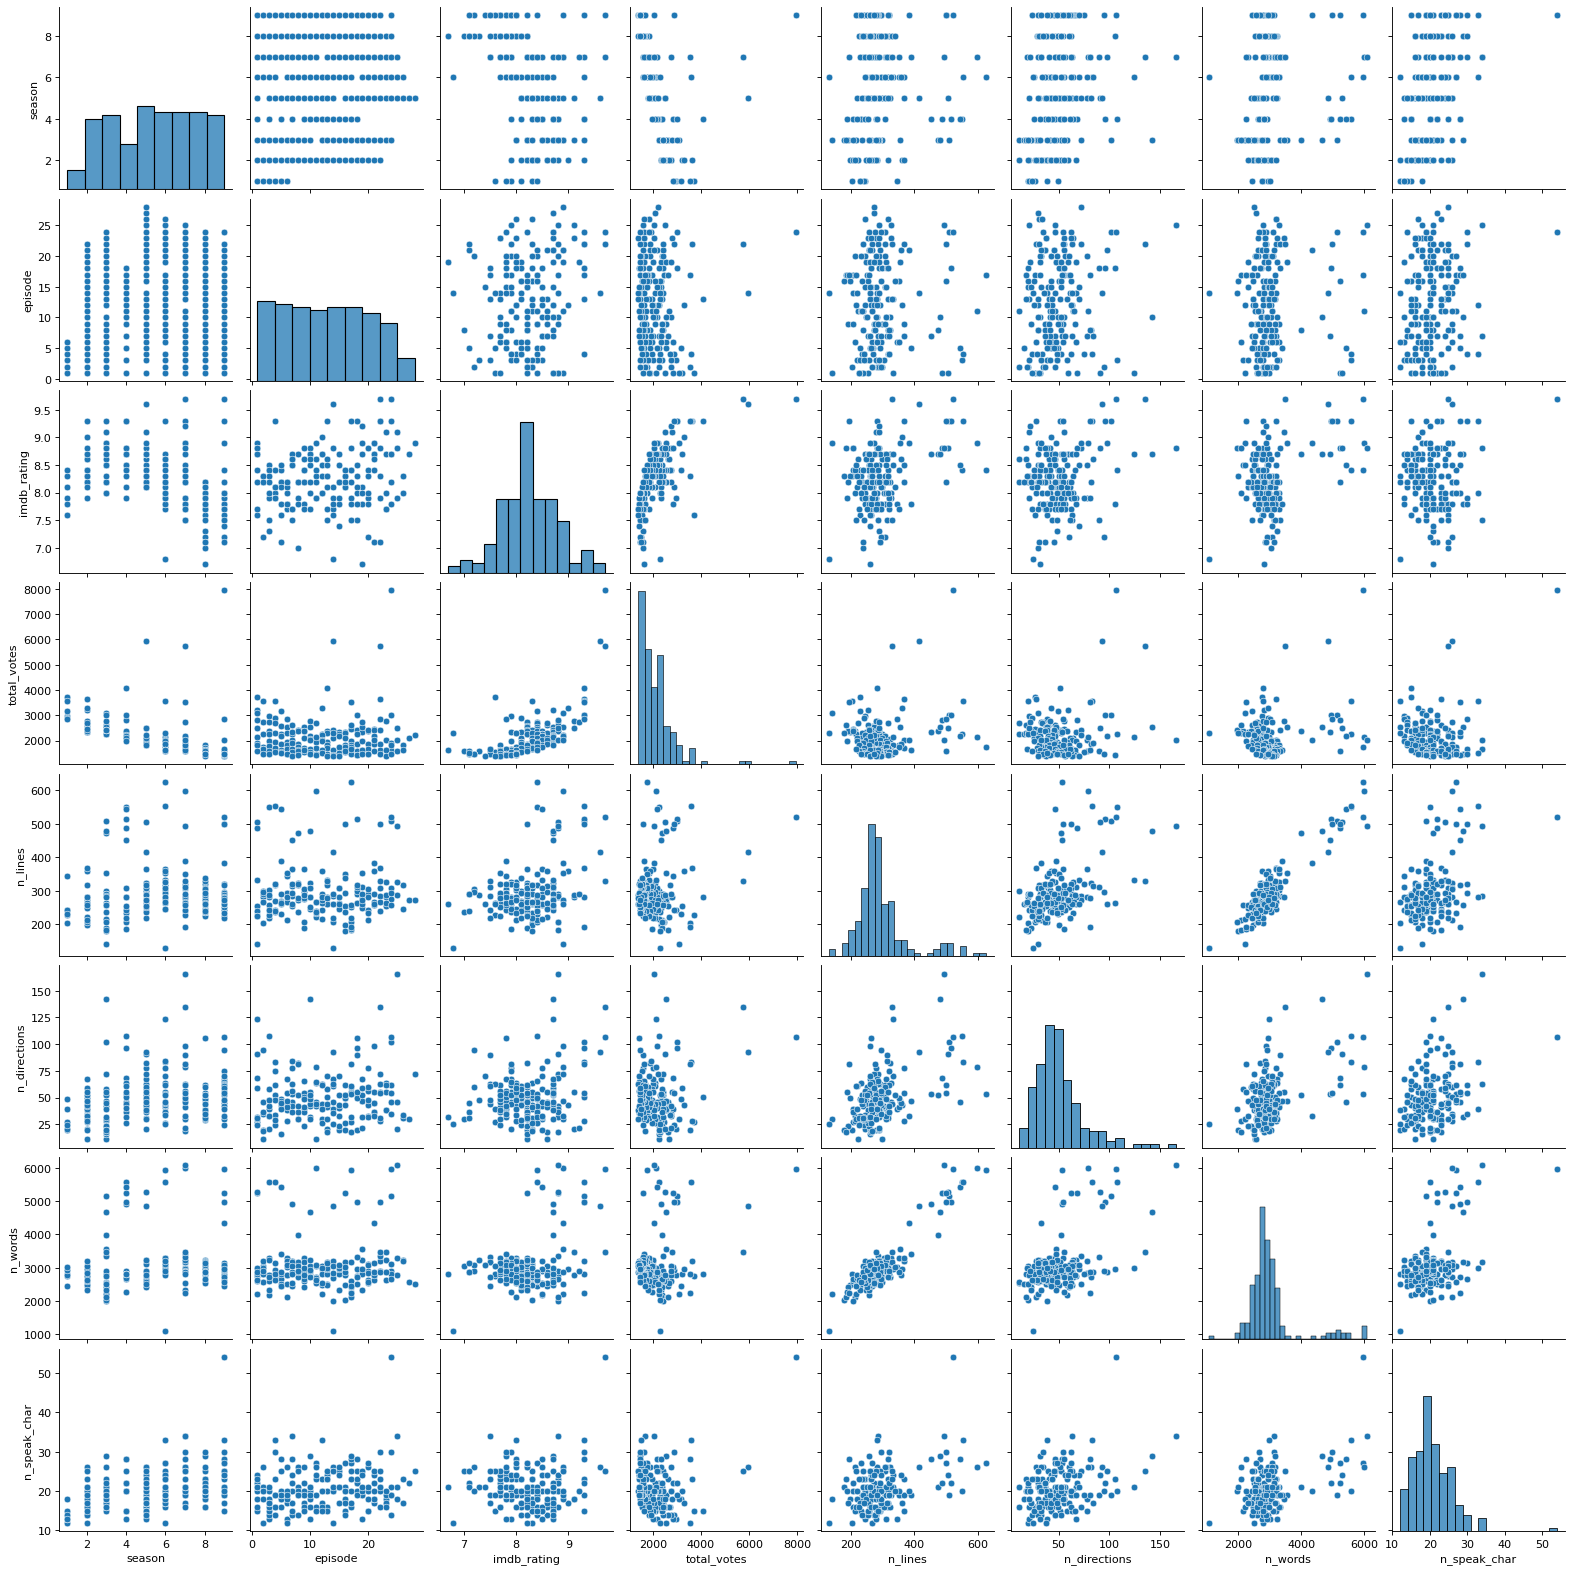

In [6]:
sns.pairplot(data)

Many of these pairplots contain little information but there are some interesting trends. 

1. Season 8 was particularly unpopular.
2. The ratings are normally distributed.
3. The number of lines and number of words are strongly correlated so we may not need both variables. 
4. There seems to be some quadratic correlation between the total votes and the imbd rating.


We then used a correlation table to see if we could get confirmation of any correlation numerically. 

In [7]:
data.corr()

/tmp/ipykernel_8748/2627137660.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


,season,episode,imdb_rating,total_votes,n_lines,n_directions,n_words,n_speak_char
season,1.000000,0.098716,-0.397731,-0.444398,0.115649,0.228935,0.146717,0.413508
episode,0.098716,1.000000,0.179985,0.020161,0.034908,0.125925,0.055552,0.184197
imdb_rating,-0.397731,0.179985,1.000000,0.653973,0.348994,0.226286,0.337212,0.091992
total_votes,-0.444398,0.020161,0.653973,1.000000,0.205062,0.182462,0.265325,0.178324
n_lines,0.115649,0.034908,0.348994,0.205062,1.000000,0.487551,0.915959,0.416188
n_directions,0.228935,0.125925,0.226286,0.182462,0.487551,1.000000,0.511985,0.350052
n_words,0.146717,0.055552,0.337212,0.265325,0.915959,0.511985,1.000000,0.480967
n_speak_char,0.413508,0.184197,0.091992,0.178324,0.416188,0.350052,0.480967,1.000000


This confirmed that there is a strong positive associaiton between number of words and lines and a moderate correlation between imdb rating and total number of votes. 

## Data refining 

To make our model as practical as possible we have made some changes to the original data set.
Firstly we cleaned up the data set and removed typos in the directors names. 

We decided to remove several features that wouldn't help us make a reccomendation as detailed below: 

It is not possible for producers to release this episode in the past and year of release may also be difficult to control, however we replaced this with a feature of season (eg Summer), as this has a correlation with date but will allow us to produce a more useful recommendation. 

We dropped total number of votes on imbd rating as although this had a strong quadratic correlation with imdb rating, the producers have no control of how many people vote on a given episode. We did briefly consider using number of votes as a response variable instead of as a feature but found this didn't add any value. 

We removed number of words to streamline the model due to its correlation with number of lines.

We also dropped episode season because the special will be in a season of its own, and thus there is no point providing a recommendation on which season to air the episode in. 

In [8]:
'''
   Data Formatting
'''
data_numeric = data.copy()
pd.options.mode.chained_assignment = None 


'''
   The imported data was seperated by semicolons so I have 
   replaced these with commas to make the data useable
'''
#Character column
for i in range(0,len(data.main_chars)):
   data_numeric.main_chars[i] = data.main_chars[i].split(';')
#Writer column
for i in range(0,len(data.writer)):
   data_numeric.writer[i] = data.writer[i].split(';')
#Director column
for i in range(0,len(data.director)):
   data_numeric.director[i] = data.director[i].split(';')



'''
   One hot encoding all of the categorical columns so they can be used
'''
#Import function for multi variable one hot encoder 
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer() #Reference this documentation at the end

#Directors
encoded_directors = pd.DataFrame(mlb.fit_transform(data_numeric['director']), columns= mlb.classes_)

#Writer
encoded_writers = pd.DataFrame(mlb.fit_transform(data_numeric['writer']), columns= mlb.classes_)

#One hot encoding the main characters
encoded_characters = pd.DataFrame(mlb.fit_transform(data_numeric["main_chars"]), columns= mlb.classes_)

In [9]:
'''
A function to remove duplicate typos in strings.
parameters:
data, the one hot encoded data frame to remove typos from
correct- the correct spelling of the string
typo- the typo spelling of the string
'''
def remove_typos(data, correct, typo):
    removed = np.zeros(shape = (186))
    data[correct] = encoded_directors[correct] + data[typo]
    data[typo] = removed
    return data.drop(typo, axis = 1)

In [10]:
#Removing all typos in the directors column
encoded_directors = remove_typos(encoded_directors,'Greg Daniels', 'Greg Daneils')
encoded_directors = remove_typos(encoded_directors,'Charles McDougal', 'Charles McDougall')
encoded_directors = remove_typos(encoded_directors,'Claire Scanlon', 'Claire Scanlong')
encoded_directors = remove_typos(encoded_directors,'Ken Whittingham', 'Ken Wittingham')
encoded_directors = remove_typos(encoded_directors,'Paul Lieberstein', 'Paul Lieerstein')

We suspected that the large number of columns for directors and writers might be problematic for our model so we reduced the number of columns by only keeping in directors who worked on a signficant number of office episodes (we chose 5 or more). More data on these directors/writers means we can more confident in our assesment of thier impact and be more convinced that any good or bad  impact they may have, is more than just a fluke. We combined all other directors/writers into a feature called 'other directors'/'other writers'.

In [11]:
# Add suffix
encoded_directors = encoded_directors.add_suffix(' dir')
encoded_writers = encoded_writers.add_suffix(' wri')


'''
Merge the less frequent directors/writers
'''
# Filter out those directors
other_directors = encoded_directors.columns[encoded_directors.sum() < 5]

# Sum to a new column 'Other directors'
encoded_directors['Other directors'] = encoded_directors[other_directors].sum(axis=1)

# Drop those directors
encoded_directors.drop(other_directors, axis=1, inplace=True)

# Filter out those writers
other_writers = encoded_writers.columns[encoded_writers.sum() < 5]

# Sum to a new column 'Other writers'
encoded_writers['Other writers'] = encoded_writers[other_writers].sum(axis=1)

# Drop those writers
encoded_writers.drop(other_writers, axis=1, inplace=True)


'''
   Joining the One hot encoded columns with the original data frame and removing the raw data
'''
data_numeric.drop(['director', 'writer'], axis=1, inplace=True)

data_numeric = data_numeric.join(encoded_writers)
data_numeric = data_numeric.join(encoded_directors)


In [12]:
'''
   Construct season variables and time-period in year from the earliest air_date
'''
# Manually specify the month for each season according to [1]
seasons = {'spring': (3, 4, 5), 
           'summer': (6, 7, 8),
           'autumn': (9, 10, 11),
           'winter': (12, 1, 2)}

for season in seasons:
   # For each season create a binary variable
   data_numeric[season] = 0
   
   for i in range(len(data_numeric)):
      # For each data point check the month info to confirm the season
      data_numeric[season][i] = int(int(data_numeric['air_date'][i].split('-')[1]) in seasons[season])


'''
   Create the only id 'season_episode' for later extra data merge
   and remove repeated columns
'''
data_numeric['season_episode'] = 's' + data_numeric['season'].astype(str) + '_e' + data_numeric['episode'].astype(str)
data_numeric.drop(['season', 'episode', 'air_date'], axis=1, inplace=True)

''' Dropping highly-correlated variable'''
data_numeric.drop(['n_words'], axis=1, inplace=True)

pd.set_option('display.max_columns', None)

For the main character information, initially we directly one-hot encoded them to create binary variables for each character to record his/her presence in a certain episode. However, we obtain an extra dataset which contains the scripts of the characters in each episode, and we then realise that instead of one-hot encoding, we could transform the scripts into the number of words said by a certain character in each episode. This does not only give the presence information (i.e. word_counts $= 0$ or $>0$) of the characters, but also quantifies how much they are presented, which might be helpful in figuring out more detailed popularities of them. We now do a elementary data exploration on that new dataset. 

In [13]:
data_scripts.sample(10)

,id,season,episode,scene,line_text,speaker,deleted
30166,30167,5,24,33,There's not a single appropriate outfit in thi...,Toby,False
16791,16792,3,23,62,Then you have been deducted 50 Schrute Bucks!,Dwight,False
19816,19817,4,6,33,"Oh no, I didn't want to see you. Not that I'm...",Jim,False
11353,11354,3,7,34,"But, I don't want to go to DJ's.",Kevin,False
1084,1085,1,4,41,"That was Stanley. 'Meredith, happy birthday, y...",Meredith,False
26874,26875,5,13,17,We had to pay for it. Cost us thirty five hun...,David Wallace,False
27091,27092,5,14,2,All right.,Jim,False
17788,17789,4,2,35,Great.,Michael,False
8212,8213,2,19,1,"Alright, let me explain. Again. [draws on boar...",Michael,False
40000,40001,7,6,27,"Um, fifteen thousand bucks, Oscar.",Kelly,False


In [14]:
# Create the id 'season_episode' according to the earlier definition
data_scripts['season_episode'] = 's' + data_scripts['season'].astype(str) + '_e' + data_scripts['episode'].astype(str)

counter = 0
# Check the episodes in our data that are not in the extra data
for s_e in data_numeric['season_episode'].unique():
    if s_e not in data_scripts['season_episode'].unique():
        counter+=1
        
print(counter)

11


In [15]:
counter = 0
# Check the sentences said simultaneously by more than one characters
for speaker in data_scripts['speaker']:
    if 'and' in speaker:
        counter += 1
        
print(counter)

129


In [16]:
len(data_scripts['speaker'].unique())

797

We have the following observations.

1. There are 11 out of 186 episodes in our data of which the new dataset does not contain information. We could assign them with the average value of the other data points.
2. In the column of the scripts of the characters, the entries also contain some scene descriptions like the action and mood settings of the characters. We decided to include them in word counts as well because the detailed script design of a character also indicates a high level of presence.
3. There are 129 out of 59909 script records simultaneously said by more than one character, that is, the corresponding character record is in the form of 'character_A and character_B'. Considering that this proportion is really small, we decided not to deal with this and simply ignore the 129 data points.
4. The scripts are from at least 600 unique speakers (considering more-than-one-char situations), and by experimenting including different numbers of speakers, we decided only to use the scripts for the 17 characters presented in the original data. 
5. The column deleted records if the corresponding scene was deleted in the final show, so we just need the data points with deleted=False.
6. The episodes in the dataset for scripts have a different naming pattern, which has caused the problem stated above (11 unmatching episodes). That is because some of the episodes of the series are concatenated to be one episode and the two datasets have dealed with it differently (e.g. for season 3, episodes 10 and 11 are concatenated to be one episode, in response to which the original dataset has episodes '9', '10', '12'..., '24' with '11' omitted, but the dataset for the scripts has episodes '9', '10', '11',... ,'23' with the gap at the end). It would take a while to match them correctly and we would do so if we got extra time. However, due to the heavy workload from other courses, we decided not to do the matching and instead introduce it as a recommendation for improving the data/model.

In [17]:
'''
    Concatenate datasets of character scripts to our data
    in a way such that each character has a word count for each episode
'''
data_scripts = data_scripts[data_scripts['deleted']==False]

# Create dataframe to contain the word counts
num_scripts = pd.DataFrame({
    'season_episode': data_numeric['season_episode'].unique()
})

# Only consider the charaters appeared in the original data
for char in tqdm(encoded_characters.columns):
    # Filter the scripts for each character
    d_slice1 = data_scripts[data_scripts['speaker'] == char]
    
    # initialise the word counts column for that character
    num_scripts[f'words_{char}'] = 0
    
    for s_e in num_scripts['season_episode']:
        if s_e in data_scripts['season_episode'].unique():
            # Filter the scripts for each episode
            d_slice2 = d_slice1[d_slice1['season_episode'] == s_e]
            
            words_count = 0
            for sentence in d_slice2['line_text']:
                # Count the numebr of words in each line with punctuations ignored
                words_count += sum(word.strip(string.punctuation).isalpha() for word in sentence.split())
                
            num_scripts[f'words_{char}'][num_scripts['season_episode']==s_e] = words_count
        else:
            num_scripts[f'words_{char}'][num_scripts['season_episode']==s_e] = -1
    
    num_scripts[f'words_{char}'][num_scripts[f'words_{char}']==-1] = num_scripts[f'words_{char}'][num_scripts[f'words_{char}']!=-1].mean()

# Merge the datasets with season_episode as the matching key
data_numeric = data_numeric.set_index('season_episode').join(num_scripts.set_index('season_episode'))

# Delete the original character column
data_numeric.drop(['main_chars'], axis=1, inplace=True)

100%|██████████| 17/17 [00:11<00:00,  1.51it/s]


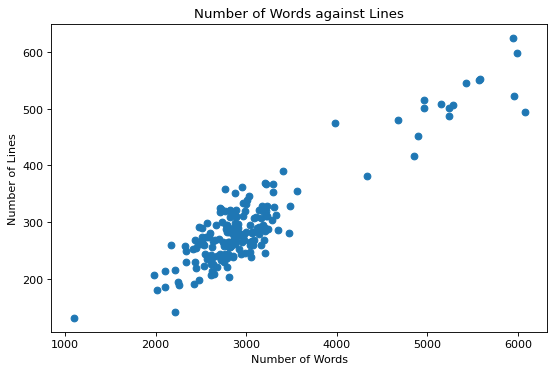

In [18]:
#Plotting two correlated variables on a larger plot
fig1, ax1 = plt.subplots()
ax1.scatter(data['n_words'], data['n_lines'])
ax1.set_xlabel("Number of Words")
ax1.set_ylabel("Number of Lines")
ax1.set_title("Number of Words against Lines")
plt.show()

A noted above number of words and number of lines appear to have a positive linear relationship, and have very high correlation coefficient of 0.91. We decided to remove one of these predictors to simplify our final model, and opted to drop number of words because it has slightly lower correlation coefficent when paired with IMDB rating. 

We noticed that there seemed to be a few episodes with significantly higher or lower ratings than the mean. A box-plot shows that some of these observations fall outwith the upper and lower boundaries of the 75th and 25th quartiles respectively (Episodes with rating of 9.7 or 6.7).

We manually searched the data file to identify these obesrvations but decided not to remove them. Removing these might provide a better model for predicting the rating of more 'average' episodes. But in the case that the studio aims for a very high rating we definitely want to include points in this range in our model. If the studio decided they wanted to identify qualities that would give a better guarantee of a more average rating, then removing these points could be considered. 

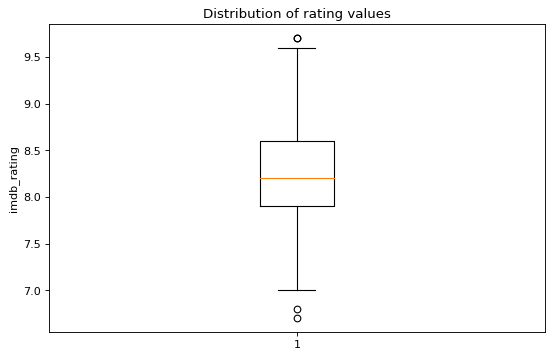

"\ndata_numeric.drop(data_numeric.index[(data_numeric['episode_name']=='Goodbye, Michael')], axis=0, inplace=True)\ndata_numeric.drop(data_numeric.index[(data_numeric['episode_name']=='Finale')], axis=0, inplace=True)\ndata_numeric.drop(data_numeric.index[(data_numeric['episode_name']=='Get The Girl')], axis=0, inplace=True)\ndata_numeric.drop(data_numeric.index[(data_numeric['episode_name']=='The Banker')], axis=0, inplace=True)\n"

In [19]:
#Outlier removal 
#Plotting a box plot of ratings to view any outlier values 
fig2, ax2 = plt.subplots()
ax2.boxplot(data['imdb_rating'] )
ax2.set_ylabel("imdb_rating")
ax2.set_title("Distribution of rating values")
plt.show()

#We can see that there are a few outlier values
'''
data_numeric.drop(data_numeric.index[(data_numeric['episode_name']=='Goodbye, Michael')], axis=0, inplace=True)
data_numeric.drop(data_numeric.index[(data_numeric['episode_name']=='Finale')], axis=0, inplace=True)
data_numeric.drop(data_numeric.index[(data_numeric['episode_name']=='Get The Girl')], axis=0, inplace=True)
data_numeric.drop(data_numeric.index[(data_numeric['episode_name']=='The Banker')], axis=0, inplace=True)
'''

As mentioned above, we decided not to include total_votes as a predictor, because it's not something the filming team can control. However, we considered that it might be a possibility to find a model to predict total_votes instead of rating. The variables have a high correlation coefficient of 0.65 and apparent quadratic relationship shown in the plot below. Total votes might be a good measure of the fame and emotion-provoking nature of an episode which it makes sense could relate to how good the episode is. So, we thought that predicting total_votes might be of benefit if this model ended up having stronger predictive ability than our best model predicting rating directly. We explored this briefly in Section 3 by following the same process to create a model for total_votes as we used to predict imdb_rating. However we didn't see any improvement in the performance metrics and so decided not to purse this idea further.  

Additionally, if we had chosen to use this as our primary model we would have needed to be careful not to infer causation. We don't know that there aren't other related variables which cause an apparent relationship between total votes cast and rating. It might be that highly-rated episodes just have more votes because they are more famous, or because people are excited to share their views on their favourite program. 

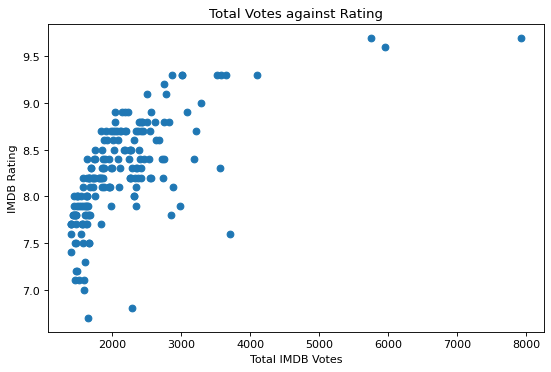

In [20]:
# We plot an individual plot of total_votes against imdb_rating

fig1, ax1 = plt.subplots()
ax1.scatter(data['total_votes'], data['imdb_rating'])
ax1.set_xlabel("Total IMDB Votes")
ax1.set_ylabel("IMDB Rating")
ax1.set_title("Total Votes against Rating")
plt.show()

## 3. Model Fitting and Tuning

We considered using linear regression which gave us an acceptable R-squared score of 0.16 but 
we dropped this model because ridge regression was a significant imporvement probably because the
basic linear model was overfitting the data.

We also considered using polynomial regression but this only gave us a good correlation between 
IMDB rating and total number of votes and there didn't seem to be a strong quadratic relationship 
with any other features. Additionally we attempted to apply the ridge method to the polynomial 
regression to see if it would help as it did with the linear model but there was little imporvement 
and all of the polynomial models had poor R-squared scores. As discussed we decided to drop total 
number of votes and the polynomial models were not useful after that. 

We began by scaling the numerical features because we noticed that there was a wide range of magnitudes of values. Then we split the data into two sets - one on which to train our model and another on which to test it's predictive ability. 

In [21]:
scaler = StandardScaler()

# Dropping text and response variables from our dataframe
X = data_numeric.drop(['imdb_rating', 
                       'episode_name', 
                       'total_votes'], axis = 1)
y = data_numeric['imdb_rating']


# Selecting only the numerical variables to be scaled, not the encoded categorical variables 
# number of words removed
bin_cols = [col for col in X.columns if (' dir' in col or ' wri' in col)] + \
    ['summer', 'winter', 'spring', 'autumn']
X_real_only = X.drop(bin_cols, axis=1)

# Creating a dataframe containing none of the numerical or text features, or response variables
# I.e. only the binary encoded variables 
X_bin_only = X[bin_cols]

#Scaling the real variables before joining the encoded columns back on
X_real_scaled = pd.DataFrame(scaler.fit_transform(X_real_only), 
                             columns = X_real_only.columns, 
                             index = X_real_only.index)
X_scaled = pd.concat([X_real_scaled, X_bin_only], axis=1)

# Splitting into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 42)
X_train.sample(5)

,n_lines,n_directions,n_speak_char,words_Andy,words_Angela,words_Creed,words_Darryl,words_Dwight,words_Erin,words_Jim,words_Kelly,words_Kevin,words_Meredith,words_Michael,words_Oscar,words_Pam,words_Phyllis,words_Ryan,words_Stanley,words_Toby,Aaron Shure wri,B.J. Novak wri,Brent Forrester wri,Charlie Grandy wri,Daniel Chun wri,Gene Stupnitsky wri,Greg Daniels wri,Halsted Sullivan wri,Jennifer Celotta wri,Justin Spitzer wri,Lee Eisenberg wri,Michael Schur wri,Mindy Kaling wri,Paul Lieberstein wri,Warren Lieberstein wri,Other writers,B.J. Novak dir,Charles McDougal dir,David Rogers dir,Greg Daniels dir,Jeffrey Blitz dir,Ken Kwapis dir,Ken Whittingham dir,Matt Sohn dir,Paul Feig dir,Paul Lieberstein dir,Randall Einhorn dir,Other directors,summer,winter,spring,autumn
season_episode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
s4_e14,-0.934212,0.454383,-0.136560,0.103650,0.840113,2.596851,-0.579759,0.108444,-0.716272,2.808138,0.366701,1.188044,1.021839,2.224806,0.151056,0.771688,4.856541,-0.286646,0.842273,7.427106,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
s6_e9,0.863341,0.161218,-0.333461,0.002203,-0.249155,0.226575,-0.654447,0.130133,0.366394,2.040394,-0.261673,0.554674,0.345075,0.018304,1.511443,-0.685757,0.174732,-0.493526,-0.054724,-0.639669,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
s5_e19,0.178559,0.705667,-1.514866,-0.574016,0.096478,-0.365994,-0.654447,-1.422790,-0.716272,-0.691873,0.225317,0.440992,-0.383747,0.340602,1.495984,0.543332,-0.619504,-0.689517,0.129952,-0.225988,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
s4_e9,-1.080951,-0.550754,0.257241,-0.586190,0.211689,-0.572105,-0.654447,-0.772124,-0.716272,0.109742,-0.811501,-1.183033,-0.670070,0.910821,-1.023824,0.402289,-0.640405,-0.689517,-0.793428,-0.639669,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
s6_e13,0.459809,0.831309,0.651043,-1.004152,-0.741420,-0.572105,-0.654447,-1.327359,-0.716272,-1.843490,-0.811501,-1.134312,-0.670070,-0.416386,-1.023824,-1.357391,-0.870315,-0.580633,-0.872575,1.001265,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0


Next we will include the two user-defined helper functions given in the Week 5 Workshop. 
These will allow us to efficiently find the coefficients of a fitted model, and view it's performance metrics on the test data. 

In [22]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold
def get_coefs(m):
    """Returns the model coefficients from a Scikit-learn model object as an array,
    includes the intercept if available.
    """
    
    # If pipeline, use the last step as the model
    if (isinstance(m, sklearn.pipeline.Pipeline)):
        m = m.steps[-1][1]
    
    
    if m.intercept_ is None:
        return m.coef_
    
    return np.concatenate([[m.intercept_], m.coef_])

def model_fit(m, X, y, plot = False):
    """Returns the mean squared error, root mean squared error and R^2 value of a fitted model based 
    on provided X and y values.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should fit plots be shown 
    """
    
    y_hat = m.predict(X)
    MSE = mean_squared_error(y, y_hat)
    RMSE = np.sqrt(mean_squared_error(y, y_hat))
    Rsqr = r2_score(y, y_hat)
    
    Metrics = (round(MSE, 4), round(RMSE, 4), round(Rsqr, 4))
    
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Actual vs Fitted plot")
        
        plt.subplot(122)
        sns.scatterplot(x='y_hat', y='resid', data=res).set_title("Fitted vs Residual plot")
        plt.hlines(y=0, xmin=np.min(y), xmax=np.max(y), linestyles='dashed', alpha=0.3, colors="black")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model (MSE, RMSE, Rsqr) = " + str(Metrics), fontsize=14)
        plt.show()
    
    return MSE, RMSE, Rsqr

We define the following function which will return to us a dataframe showing the features with the largest coefficients in our fitted model. This allows us to easily interpret the results of our models.  

In [23]:
def get_impt_features(pipeline, input_df, k, positive = False):
    '''
        Get k most important features with the largest model coefficients (by absolute value if positive = True)
    '''
    mean = get_coefs(pipeline)[0]
    coefs = get_coefs(pipeline)[1:]
    
    if positive == True: 
        impt_idx = np.argsort(-coefs)[:k]
    else: 
        impt_idx = np.argsort(-np.abs(coefs))[:k]
        
    features = ['Intercept'] + list(pipeline[:-1].get_feature_names_out(input_df.columns)[impt_idx])
    coefficients = [mean] + list(coefs[impt_idx])
    
    return pd.DataFrame({
        'Features': features,
        'Coefficients': coefficients
    })
    

Below we include our implementation of a basic Ridge-Regression model, before tuning to find the parameter value which gives a model with the lowest root-mean-squared-error value (on the training data).  

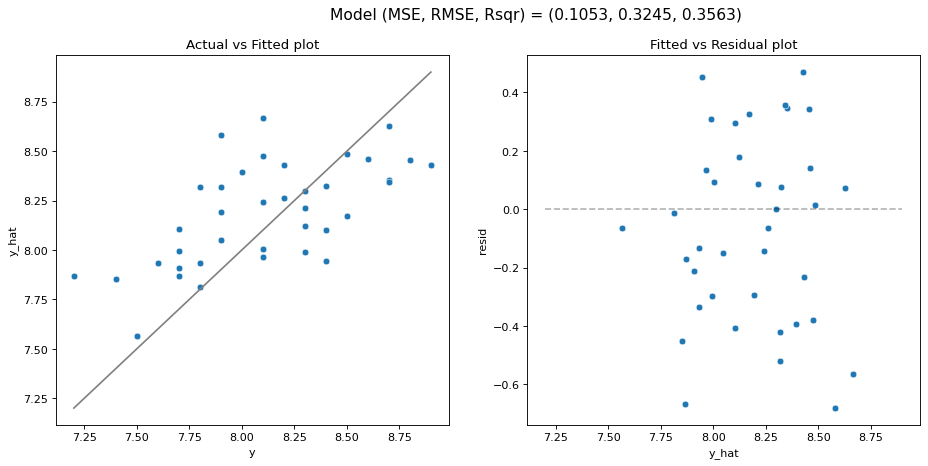

(0.10529403278995696, 0.3244904201821018, 0.3562888088539464)

In [24]:
# First attempt at Ridge Regression 
from sklearn.linear_model import Ridge

#Setting alpha value
a = 100

#Fitting the ridge regression model to the training set
ridge_scaled = make_pipeline(
    StandardScaler(),
    Ridge(alpha = a)
).fit(X_train, y_train)

#Testing the ridge regression model on the testing set
model_fit(ridge_scaled, X_test, y_test, plot = True)


{'ridge__alpha': 183.30550918196994}


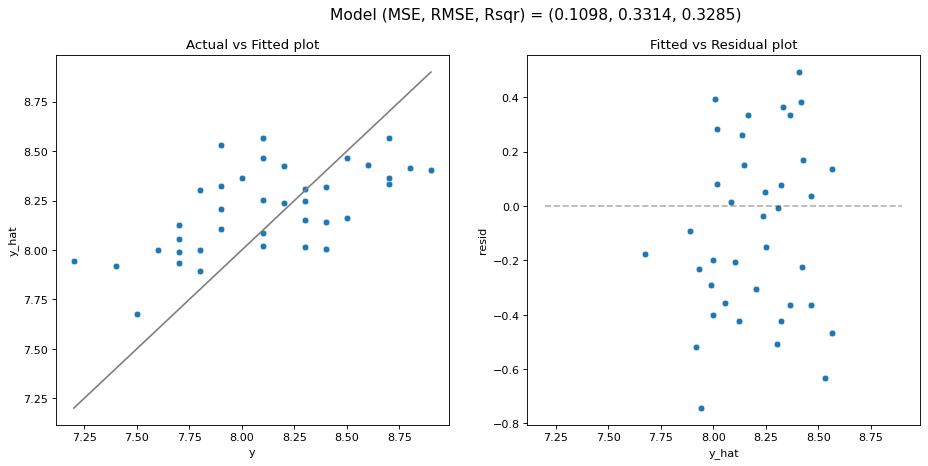

(0.10984680109252676, 0.33143144252247214, 0.3284556275291759)

In [25]:
#We implement parameter tuning using the grid search method given in Workshop 5

alphas = np.linspace(0, 300, num=600)

#Searching the parameter values for the one that gives best RMSE
gs = GridSearchCV(
    make_pipeline(
        StandardScaler(),
        Ridge()
    ),
    param_grid = {'ridge__alpha': alphas},
    cv = KFold(5, shuffle = True, random_state = 42),
    scoring = "neg_root_mean_squared_error"
)
# Note: We have already scaled the numerical data, but including the standard scaler in the model pipeline
# results in better predictive performance below. This may be due to benefit from scaling the columns 
# of encoded categorical variables, each of which contains a varying number of 1s vs 0s. 

# Fitting and evaluating the model with the best parameter choice
gs.fit(X_train, y_train)
print(gs.best_params_)
model_fit(gs.best_estimator_, X_test, y_test, plot=True)

When we implemented the grid search for alpha between 0 and 60 as in the Week 5 Workshop, we found that the best alpha value was being returned as 60. Hence we increased the search range and found an optimal value of 183.3. 

The R-suqared and RMSE values for this best-alpha-value implementation are actually slightly worse than the results when alpha = 100. However, our optimised alpha value was the one deemed best during 5-fold cross-validation of our training set. So we think that the model using the tuned alpha value would perform better on average on other testing sets or new observations. 

In [26]:
get_impt_features(gs.best_estimator_, X_train, 20)

,Features,Coefficients
0,Intercept,8.286486
1,n_lines,0.066472
2,words_Michael,0.059083
3,Other writers,-0.046830
4,n_directions,0.046154
5,words_Erin,-0.042564
6,Paul Feig dir,0.036561
7,Greg Daniels wri,0.032977
8,Paul Lieberstein wri,0.031819
9,Greg Daniels dir,0.026352


## 4. Discussion and Conclusions
Our model coeffiecents tell us that total number of lines and directions are the strongest predictors of episode rating. To interpret this into actionable recommendations, this firstly could be interpreted as episodes with lots of dialogue and lots of action will do well. But it also should be noted that longer episodes will naturally have more lines and direction in them and thus this higher coefficent could be an indicator that longer epsiodes will have a higher overall imdb rating. 

Characters whose number of words in scripts have relatively large positive corresponding coefficients include Michael, Stanley and Creed, with Michael the most positive. This makes sense because through research we found that Michael left the series at season 8, and season 8 was indicated to be remarkably less popular than other seasons in our earlier data exploration. These coefficients are each of magnitude two or three times less than that of number of lines, so our recommendation to include them in a new episode is secondary. It seems that the audience does not want Erin to talk much as her number of scripts has the most negative coefficient among those of all characters. However, through manually exploration we found that Erin's first presence in this series is at season 5. Considering the decreasing tendency of the series' overall popularity over time. Erin's negative effects may not be attributed to the character itself, but to the overall quality. We also see that some of the most famous charaters Ryan, Andy, Dwight and Darryl have small but negative coefficents. Perhaps this indicates that regular episodes with the most common characters is tend to do less well. 

Greg Daniels, Paul Lieberstein and B.J. Novak are highlighted as writers with positive coefficents. Examining the database manually, we see that these writers do consistently produce good episodes. Paul Feig and Greg Daniels are highlighted as the directors with the most positive coefficients. Similarly, when we examine the data manually we can see that these directors produce consistently good episodes. Another thing to note is that the varible 'Other writers' has a very high negative effects, which might imply that the writers having experiences in this series are tended to produce better episodes.

The variable representing the season spring has a small positive coefficient, hence this may be an optimal time to release a new episode. 

Overall, our main recommendation to the studio is to write a new episode with a lot of dialogue, directions and that is similar in length to the longer episodes. We can make further recommendations including:

- to hire Greg Daniels, Paul Lieberstein or B.J. Novak as writers and Paul Feig or Greg Daniels as director
- to have more conversations arranged for Michael, Stanley or Creed
- to involve lots of side-characters in the new episode, possibly a reunion special
- release the episode in spring

However, these recommendations are not necessarily very strong because of the very small model coefficients. The corresponding coefficients are so small that it is not necessarily justified to hire or rule-out writers based on this. Taking on the recommendation to involve many characters, or publish the episode in spring would be harmless. But it might be unfair to make hiring decisions based on minute differences in model coefficients which can't reflect every aspect of a writer/director's individual talent. Hence we make the above recommendations with the aim of positively influencing episode performance, but would advise the studio to use their professional judgement and experience first and foremost. 

## 5. References

[1] Home - Achtergrond (2009). Available at: https://web.archive.org/web/20090327085605/http://www.knmi.nl/cms/content/22141/begin_van_de_lente.

[2] The Office Script lines (no date). Available at: https://www.kaggle.com/datasets/lillitarhea/the-office-script-lines.
